# Linear Regression Basic

## Load Libraries, Train, Test

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

In [3]:
print( train.shape )
train.head()

(122265, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

In [5]:
print(test.shape)
test.head()

(25080, 3)


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


# Data EDA

In [6]:
train.cfips.value_counts()

1001     39
39133    39
39089    39
39091    39
39093    39
         ..
21113    39
21115    39
21117    39
21119    39
56045    39
Name: cfips, Length: 3135, dtype: int64

In [7]:
test.cfips.value_counts()

1001     8
39133    8
39089    8
39091    8
39093    8
        ..
21113    8
21115    8
21117    8
21119    8
56045    8
Name: cfips, Length: 3135, dtype: int64

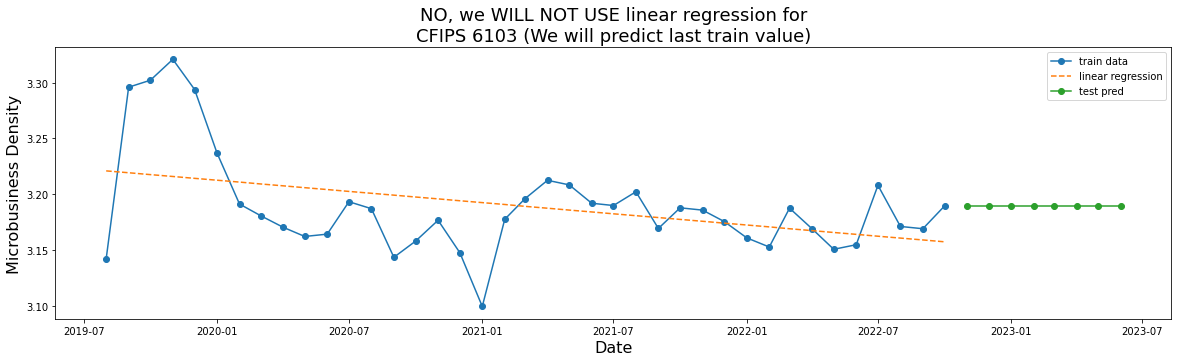

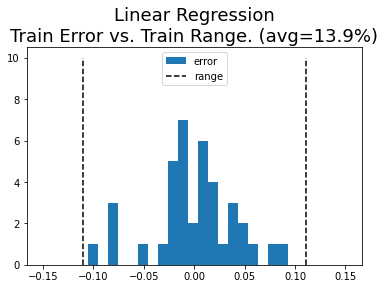

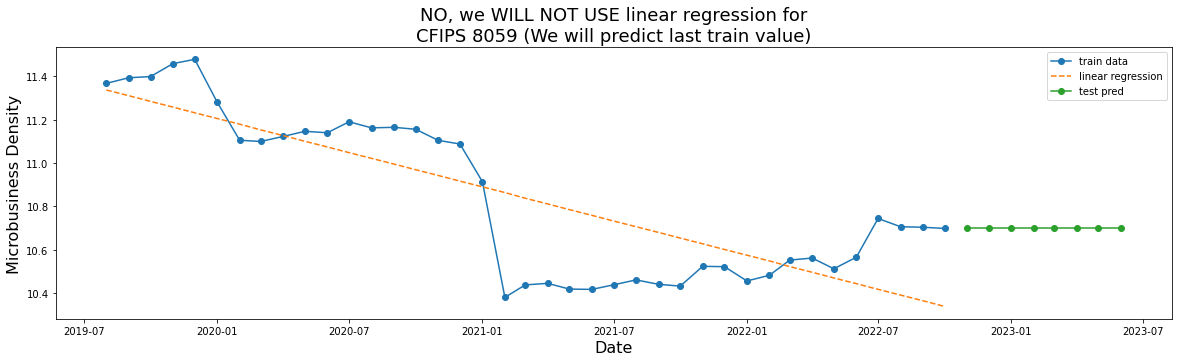

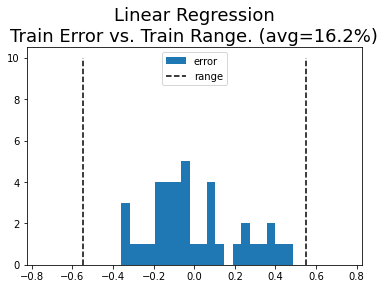

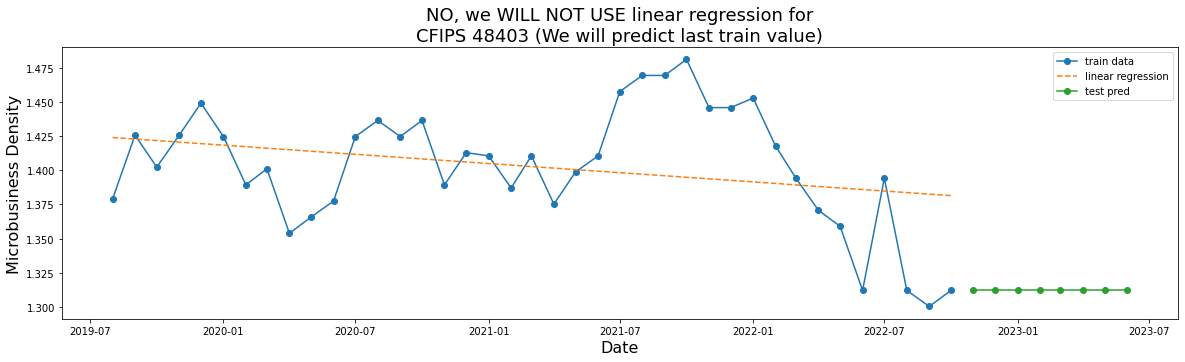

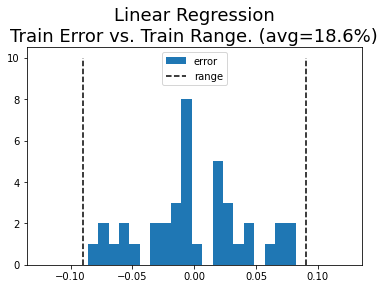

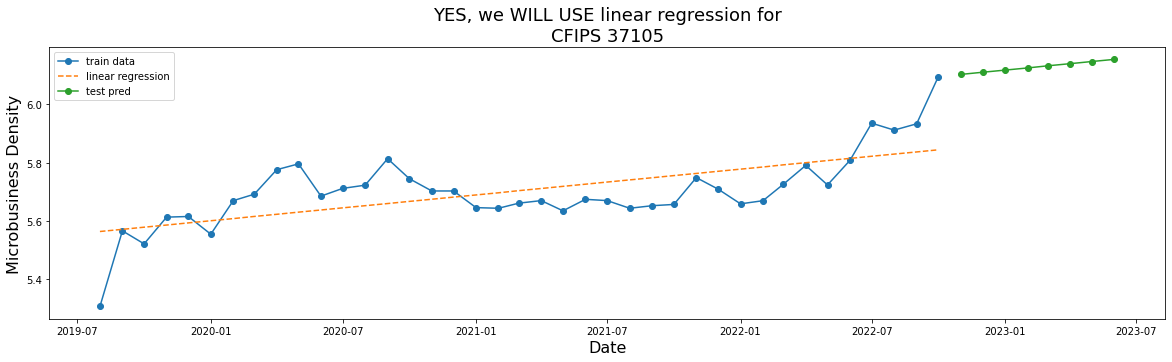

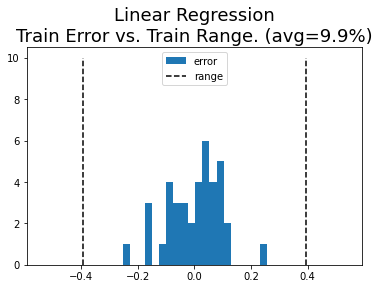

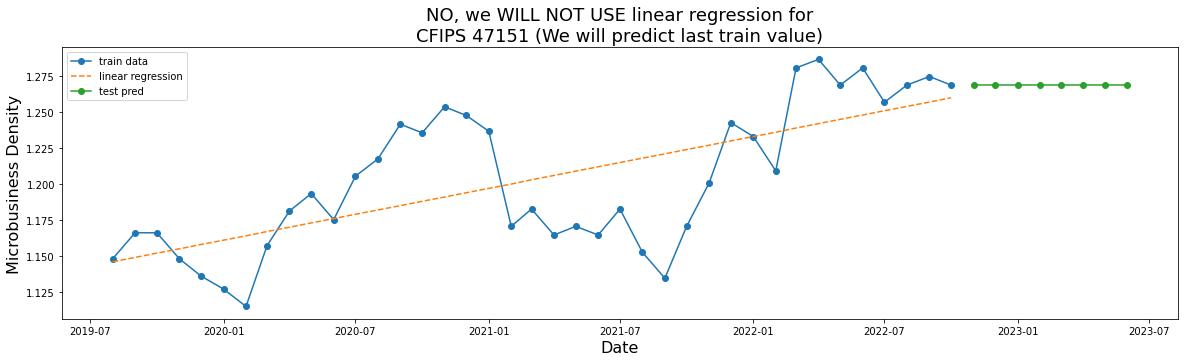

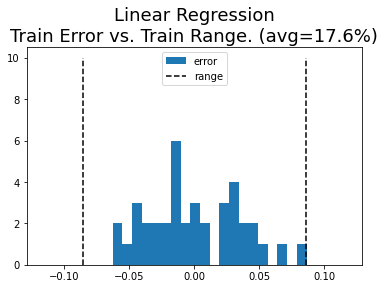

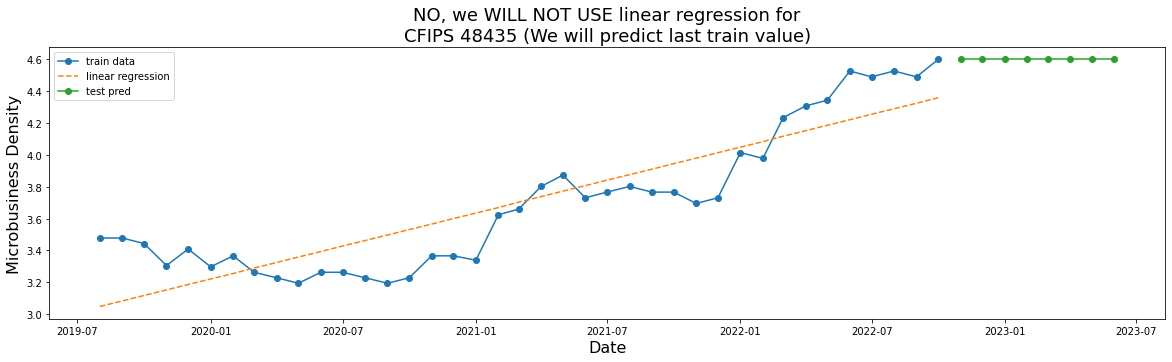

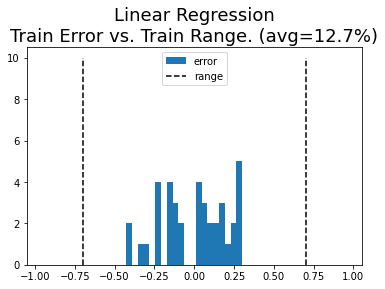

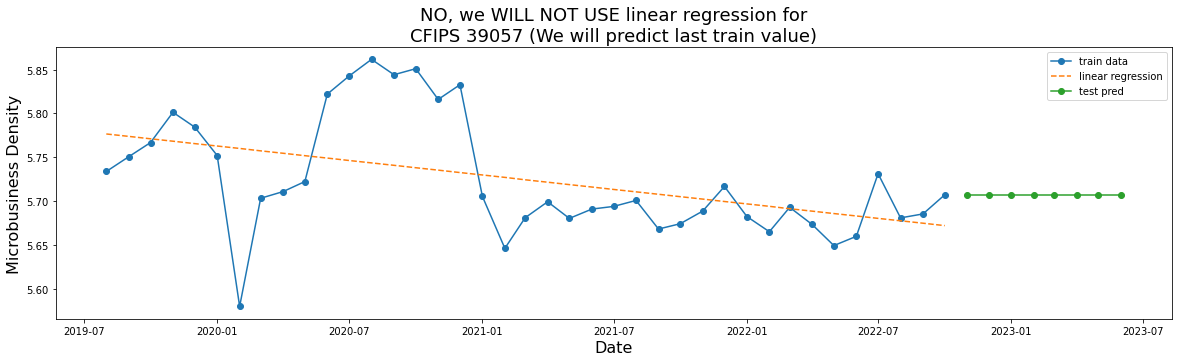

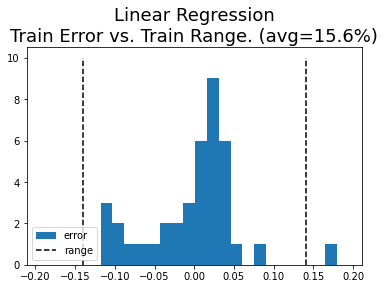

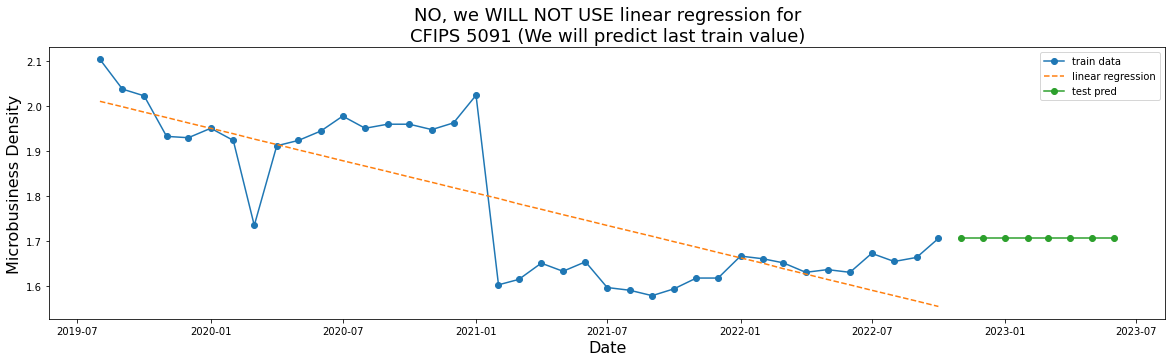

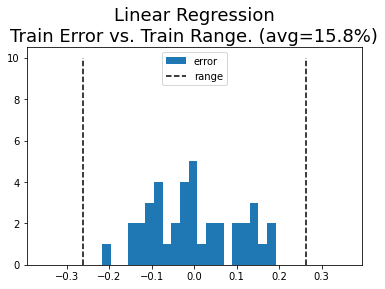

In [8]:
DISPLAY = 8
THRESHOLD = 0.103

IDS = train.cfips.unique()
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(38,47).reshape((-1,1))

for i in range(DISPLAY):
    c = np.random.choice(IDS)
    df = train.loc[train.cfips==c]
    last = df.microbusiness_density.values[-1]
    
    # FIT LINEAR REGRESSION
    model = LinearRegression()
    model.fit(x_train,df.microbusiness_density)
    p = model.predict(x_train)
    
    # COMPUTE TRAIN ERROR
    err = p - df.microbusiness_density.values
    rng = df.microbusiness_density.max() - df.microbusiness_density.min()
    
    # DETERMINE IF TIME SERIES IS LINEAR OR NOT
    s = 0
    for k in range(39):
        e = np.abs( err[k] )
        r = e/rng # absolute error divided by range
        s += r
    s = s/39 # now S is MAPE mean absolute percentage error
        
    # INFER TEST DATA WITH LINEAR REGRESSION
    p2 = model.predict(x_test)
    shift =  last - p2[0]
    if s<THRESHOLD: preds = p2[1:]+shift
    else: preds = [last]*8
     
    # PLOT STUFF
    plt.figure(figsize=(20,5))
    plt.plot(df.first_day_of_month,df.microbusiness_density,'-o',label='train data')
    plt.plot(df.first_day_of_month,p,'--',label='linear regression')
    plt.plot(test.first_day_of_month.values[:8],preds,'-o',label='test pred')
    pre = ''; post=''
    if s>THRESHOLD: 
        pre='NO, we WILL NOT USE linear regression for\n'
        post=' (We will predict last train value)'
    else: 
        pre='YES, we WILL USE linear regression for\n'
    plt.title(f'{pre}CFIPS {c}{post}',size=18)
    plt.xlabel('Date',size=16)
    plt.ylabel('Microbusiness Density',size=16)
    plt.legend()
    plt.show()
    
    plt.hist(err,bins=20,label='error')
    plt.plot([-rng/2,-rng/2],[0,10],'--',color='black',label='range')
    plt.plot([rng/2,rng/2],[0,10],'--',color='black')
    plt.xlim((-rng * 0.75,rng * 0.75))
    plt.legend()
    plt.title(f'Linear Regression\nTrain Error vs. Train Range. (avg={100*s:2.1f}%)',size=18)
    plt.show()
    print('\n\n\n\n\n\n')

# Train and Infer Linear Regression
For each of 3135 time series, we model with linear regression and compute the error of train data vs. predicted train data. If the average error is less than 10% of the range of train values, we assume the time series has a linear trend. For these 486 counties we use linear regression to predict test. For the other 2649, we use the last known value in train and the test prediction.

UPDATE in version 9: As an experiment, we will only assume linear trend only if county has more than 25,000 `active`. The train data column `active` indicates the size of the population in county. I think a trend involving more people should be more likely to continue to occur. With this additional restriction, we will use linear model for 32 counties and "last value" for 3103 counties. Let's see what LB it achieves...

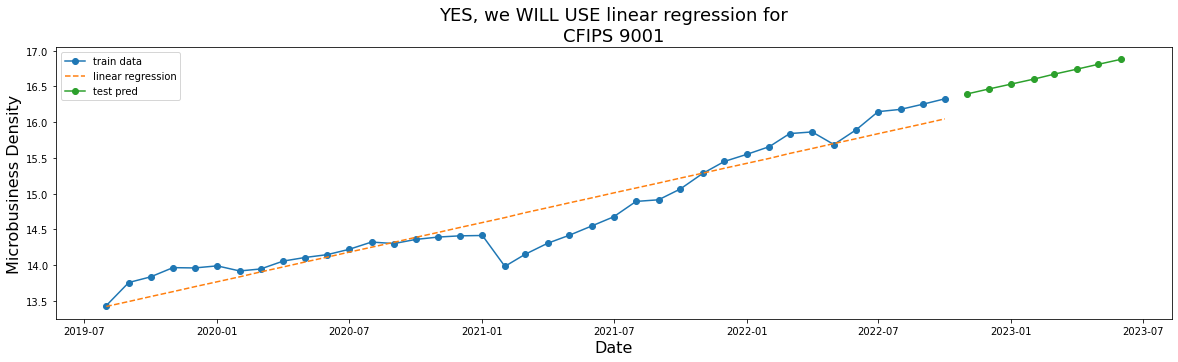

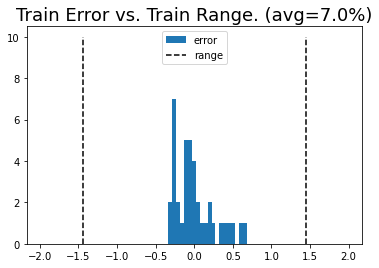

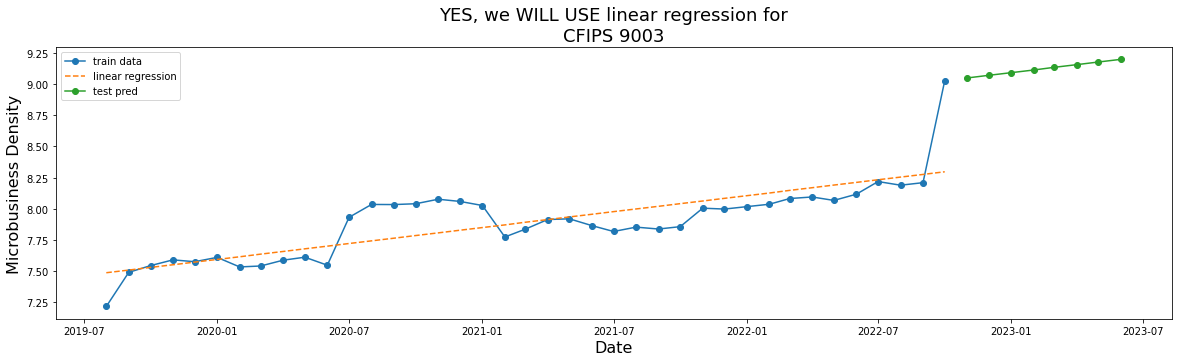

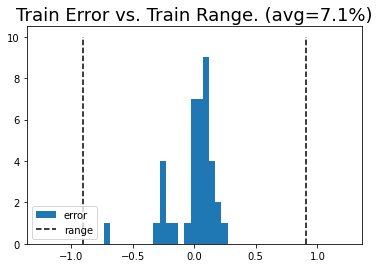

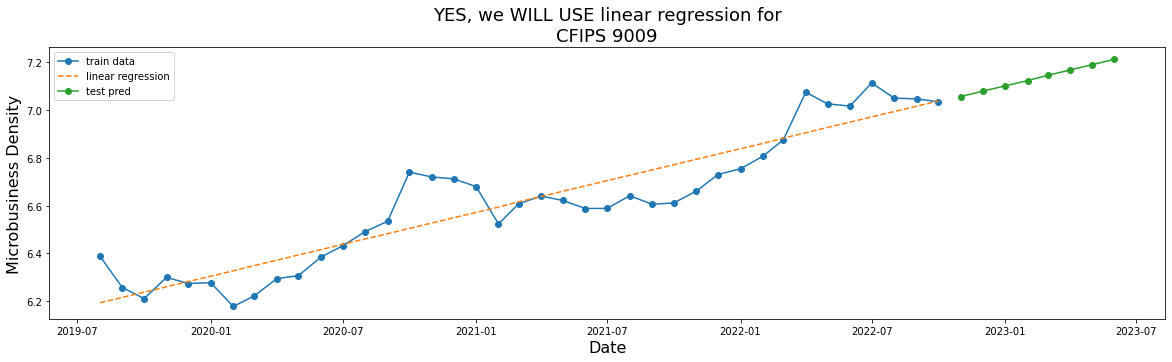

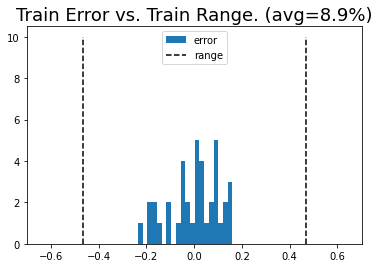

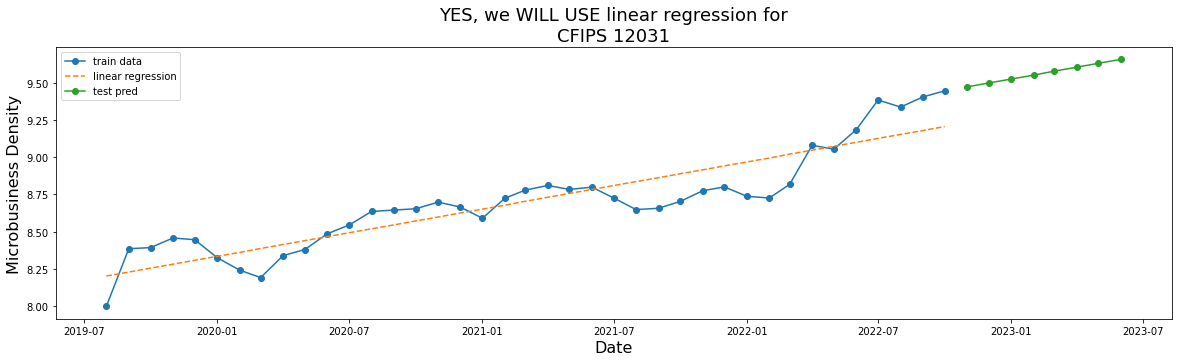

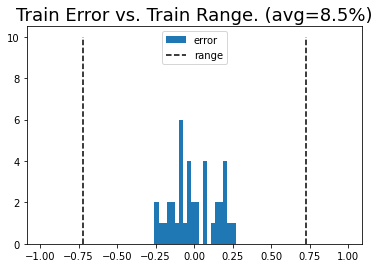

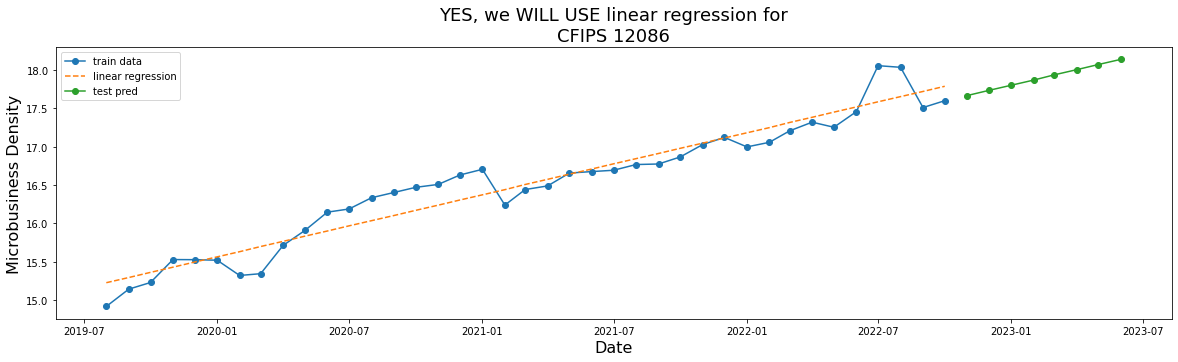

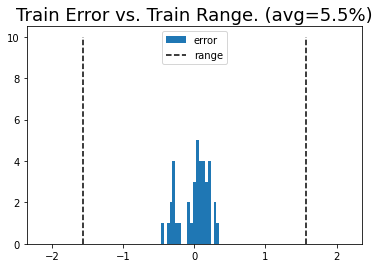

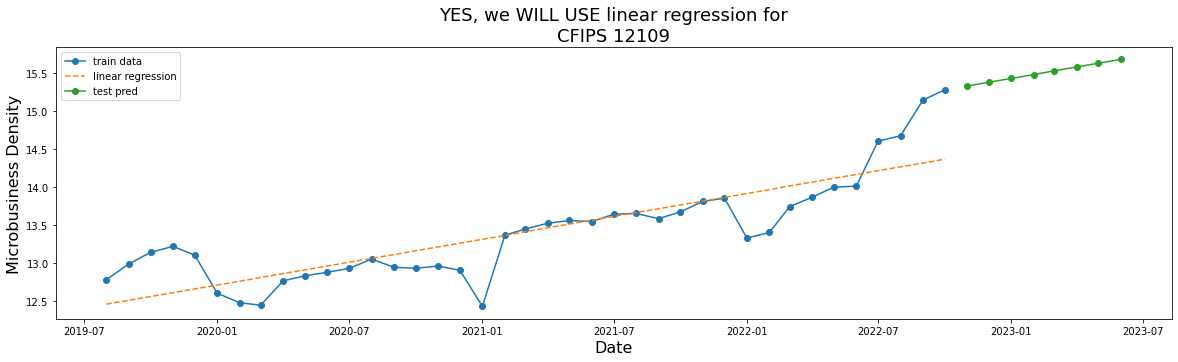

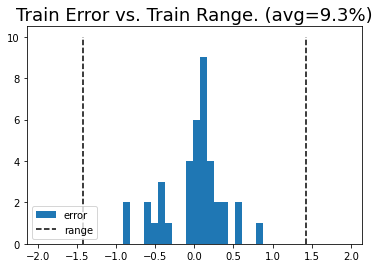

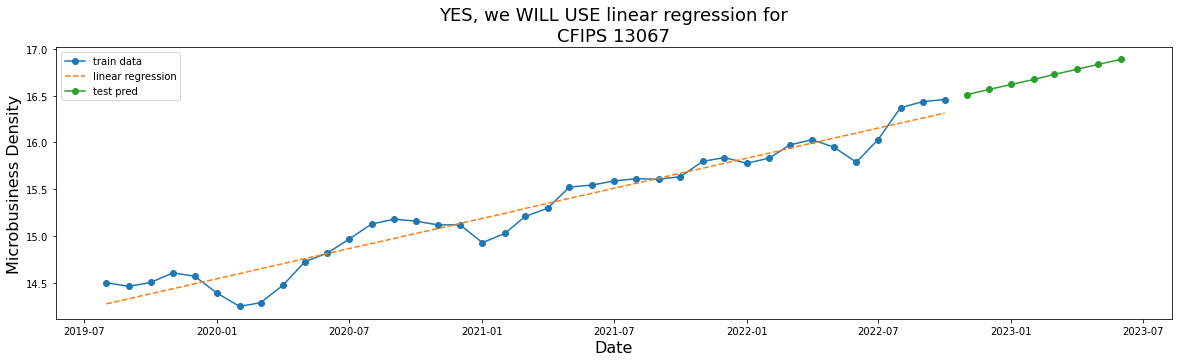

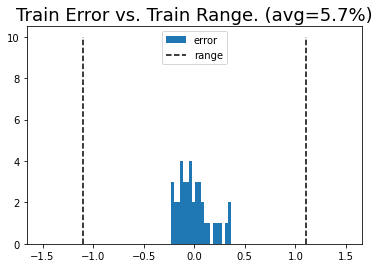

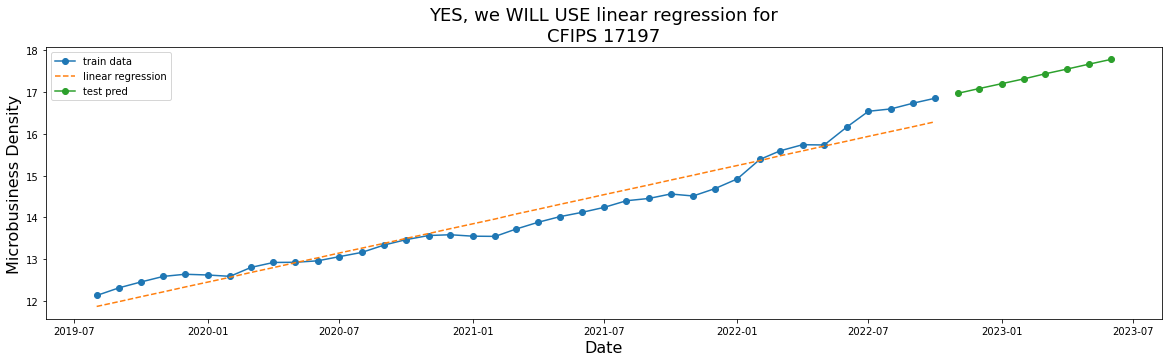

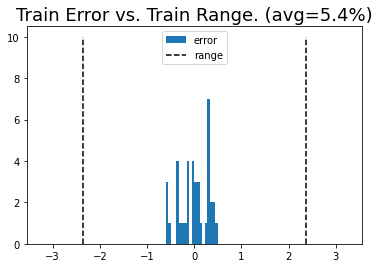








There are 32 counties with both a linear trend and large population.


In [9]:
DISPLAY = 8
THRESHOLD = 0.103 #this is 10.3% same value as 8/78 from old notebook
ACTIVE_THRESHOLD = 25_000

IDS = train.cfips.unique()
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(38,47).reshape((-1,1))

preds = np.zeros((len(IDS),8))
last_preds = np.zeros((len(IDS),8))
lin_trend = 0

ct = 0
for i,c in enumerate(IDS):
    df = train.loc[train.cfips==c]
    last = df.microbusiness_density.values[-1]
    active = df.active.values[-1]
    last_preds[i,] = [last]*8
    
    # FIT LINEAR REGRESSION
    model = LinearRegression()
    model.fit(x_train,df.microbusiness_density)
    p = model.predict(x_train)
    
    # COMPUTE TRAIN ERROR
    err = p - df.microbusiness_density.values
    rng = df.microbusiness_density.max() - df.microbusiness_density.min()
    
    # DETERMIN IF TIME SERIES IS LINEAR OR NOT
    s = 0
    for k in range(39):
        e = np.abs( err[k] )
        r = e/rng # absolute error divided by range
        s += r
    s = s/39 # now S is MAPE mean absolute percentage error
    
    # IF S <= 10% THEN WE ASSUME THIS COUNTY HAS A LINEAR TREND
    if (s>THRESHOLD)|(active<ACTIVE_THRESHOLD): 
        preds[i,] = [last]*8
        continue
        
    # INFER TEST DATA WITH LINEAR REGRESSION
    p2 = model.predict(x_test)
    shift =  last - p2[0]
    preds[i,] = p2[1:]+shift
    
    # COUNT STUFF
    ct += 1
    lin_trend += 1
    if ct>=DISPLAY+1: continue
        
    # PLOT STUFF
    plt.figure(figsize=(20,5))
    plt.plot(df.first_day_of_month,df.microbusiness_density,'-o',label='train data')
    plt.plot(df.first_day_of_month,p,'--',label='linear regression')
    plt.plot(test.first_day_of_month.values[:8],preds[i,],'-o',label='test pred')
    pre='YES, we WILL USE linear regression for\n'
    plt.title(f'{pre}CFIPS {c}',size=18)
    plt.xlabel('Date',size=16)
    plt.ylabel('Microbusiness Density',size=16)
    plt.legend()
    plt.show()
    
    plt.hist(err,bins=20,label='error')
    plt.plot([-rng/2,-rng/2],[0,10],'--',color='black',label='range')
    plt.plot([rng/2,rng/2],[0,10],'--',color='black')
    plt.xlim((-rng * 0.75,rng * 0.75))
    plt.legend()
    plt.title(f'Train Error vs. Train Range. (avg={100*s:2.1f}%)',size=18)
    plt.show()
    print('\n\n\n\n\n\n')
    
# PRINT HOW MANY LINEAR TIME SERIES WE FOUND
print(f'There are {lin_trend} counties with both a linear trend and large population.')

# Write Submission CSV

In [10]:
# NOTE TEST IS SORTED BY CFIPS AND DATA. ADD PREDS TO DATAFRAME
test['microbusiness_density'] = preds.reshape((-1))
sub = test[['row_id','microbusiness_density']]
sub.to_csv('submission.csv',index=False)
print( sub.shape )
sub.head()

(25080, 2)


,row_id,microbusiness_density
0,1001_2022-11-01,3.463856
1,1001_2022-12-01,3.463856
2,1001_2023-01-01,3.463856
3,1001_2023-02-01,3.463856
4,1001_2023-03-01,3.463856
